## Packages

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from warnings import filterwarnings
from pprint import pprint
import pickle
filterwarnings("ignore")
%matplotlib inline

## Global Parameters

In [8]:
ROOT_DIRECTORY = "/home/kaan.aytekin/Thesis"
#ROOT_DIRECTORY = "/Users/kaan.aytekin/Desktop/Kaan/Thesis"
SIMULATION_DURATION = 90 * 60 #Seconds
WARM_UP_PERIOD_DURATION = 15 * 60 #Seconds
COOL_DOWN_PERIOD_DURATION = 15 * 60 #Seconds
DETECTOR_SEPARATION_DISTANCE = 500 #Meter
DETECTOR_COUNT = 21
TOTAL_ROAD_LENGTH = DETECTOR_COUNT * DETECTOR_SEPARATION_DISTANCE

### UDFs

In [109]:
def timeit(func):
    """Wrapper function for logging the function duration

    Args:
        func (function): Function to measure performance

    Returns:
        function: Function with performance measurement capabilities
    """
    from functools import wraps
    import datetime as dt
    @wraps(func)
    def timed(*args, **kwargs):
        function_name = func.__name__
        start_time = dt.datetime.now()
        result = func(*args, **kwargs)
        end_time = dt.datetime.now()
        execution_duration = (end_time - start_time).total_seconds()
        print(
            f"Function {function_name!r} executed in {execution_duration:.4f} seconds ({execution_duration/60:.2f} minutes)")
        return result
    return timed
@timeit
def plot_detector_timelines(df, detector_metric, detector_numbers, simulation_configs):
    detector_metric_name_map = {
        "flow_vehph": "Flow(Veh/Hr)",
        "density_vehpkm": "Density(Veh/Km)",
        "avg_speed_kmph": "Speed(Km/Hr)",
        "section_travel_time_sec": "Travel Time(Sec)",
        "delay_time_sec": "Delay Time(Sec)",
    }
    detector_metric_name = detector_metric_name_map[detector_metric]
    # Data Filtering
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df[key] == value)
        else:
            simulation_selector = df[key] == value
    detector_selector = None
    for detector in detector_numbers:
        if detector_selector is not None:
            detector_selector = (detector_selector) | (
                df["detector_number"] == detector
            )
        else:
            detector_selector = df["detector_number"] == detector
    plotting_columns = {
        "x": "timestamp",
        "y": detector_metric,
        "hue": "detector_number",
        # "style":"detector_number"
    }
    plotting_df = df[simulation_selector & detector_selector][
        list(set(plotting_columns.values()))
    ]
    # Plotting helpers
    max_metric_point = plotting_df[detector_metric].max()
    detector_numbers_str = f"{detector_numbers}".strip("[]")
    accident_start_time = simulation_configs["accident_start_time"]
    accident_duration = simulation_configs["accident_duration"]
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    title = f"{detector_metric_name.split('(')[0]} distribution for Detector(s) {detector_numbers_str}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    # Plotting
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=plotting_df,
        palette=sns.color_palette("husl", len(detector_numbers)),
        **plotting_columns,
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel=detector_metric_name)
    plt.vlines(
        x=accident_start_time,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.vlines(
        x=accident_start_time + accident_duration,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.show()

def prepare_data_for_prediction(df,simulation_configs,scaler,encoder):
    df_copy = df.copy()
    accident_lane_df = pd.DataFrame(encoder.transform(df_copy[["accident_lane"]]).toarray())
    df_copy = df_copy.reset_index(drop=True)
    accident_lane_df = accident_lane_df.reset_index(drop=True)
    accident_lane_df.columns = encoder.get_feature_names(["accident_lane"])
    df_concat = pd.concat([accident_lane_df,df_copy],axis = 1)
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df_concat[key] == value)
        else:
            simulation_selector = df_concat[key] == value
    
    df_reduced = df_concat[simulation_selector]
    df_model = df_reduced[FEATURE_COLUMNS]
    df_model_scaled = scaler.transform(df_model)    
    return df_model_scaled, df_reduced.target.values

def get_delay_predictions(df,simulation_configs):
    df_model, y_real = prepare_data_for_prediction(
        df=df,
        simulation_configs=simulation_configs,
        scaler=min_max_scaler,
        encoder=one_hot_encoder
    )
    y_pred = rf_regressor.predict(df_model)
    prediction_error = y_pred - y_real
    cumulative_error = np.cumsum(prediction_error)
    result_df = pd.DataFrame(
        {
            "actual_delay": y_real,
            "predicted_delay": y_pred,
            "prediction_error": prediction_error,
            "cumulative_error": cumulative_error
        }
    )
    return result_df

def plot_delay_predictions(df,simulation_configs):
    result_df = get_delay_predictions(df,simulation_configs)
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    detector_number = simulation_configs.get("detector_number")
    title = f"Delay prediction for Detector {detector_number}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=result_df,
        palette=sns.color_palette("husl", 4),
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel="Delay Time(sec)")

### Load Data

In [49]:
processed_feature_columns_path = os.path.join(
    ROOT_DIRECTORY, "data/thesis_data/processed_feature_columns.txt"
)
with open(processed_feature_columns_path, "r") as reader:
    FEATURE_COLUMNS = reader.read().split("\n")

top_features_df = pd.read_csv(os.path.join(ROOT_DIRECTORY,"data/thesis_data/top_features.txt"))
selected_features = top_features_df.feature.to_list()
non_feature_columns = [
    "simulation_run", 
    "is_accident_simulation", 
    "accident_lane", 
]

df_train = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/x_train.csv")
)
y_train = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/y_train.csv")
)
df_train["target"] = y_train
df_test = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/x_test.csv")
)
y_test = pd.read_csv(
    os.path.join(ROOT_DIRECTORY, "data/thesis_data/y_test.csv")
)
df_test["target"] = y_test

df = df_train.append(df_test)

In [50]:
df.head()

,simulation_run,is_accident_simulation,accident_location,accident_start_time,accident_duration,accident_lane,prev_detector_detector_number,next_detector_detector_number,detector_number,timestamp,...,prev_detector_density_vehpkm_lag9,prev_detector_avg_speed_kmph_lag9,prev_detector_section_travel_time_sec_lag9,prev_detector_delay_time_sec_lag9,prev_detector_flow_vehph_lag10,prev_detector_density_vehpkm_lag10,prev_detector_avg_speed_kmph_lag10,prev_detector_section_travel_time_sec_lag10,prev_detector_delay_time_sec_lag10,target
0,0,0,0,0,0,0,1.0,2.0,1,915,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,11.776478
1,0,0,0,0,0,0,1.0,2.0,1,930,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,18.261579
2,0,0,0,0,0,0,1.0,2.0,1,945,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,25.441548
3,0,0,0,0,0,0,1.0,2.0,1,960,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,15.226153
4,0,0,0,0,0,0,1.0,2.0,1,975,...,13.652174,49.2,36.585366,19.343987,1440.0,13.652174,49.2,36.585366,19.343987,20.770317


### Load Model & Scalers

In [25]:
with open(os.path.join(ROOT_DIRECTORY,"model/random_forest_regressor.pkl"),"rb") as file:
    rf_regressor = pickle.load(file)

with open(os.path.join(ROOT_DIRECTORY,"model/min_max_scaler.pkl"),"rb") as file:
    min_max_scaler = pickle.load(file)

with open(os.path.join(ROOT_DIRECTORY,"model/one_hot_encoder.pkl"),"rb") as file:
    one_hot_encoder = pickle.load(file)
    

### Plot Prediction Results

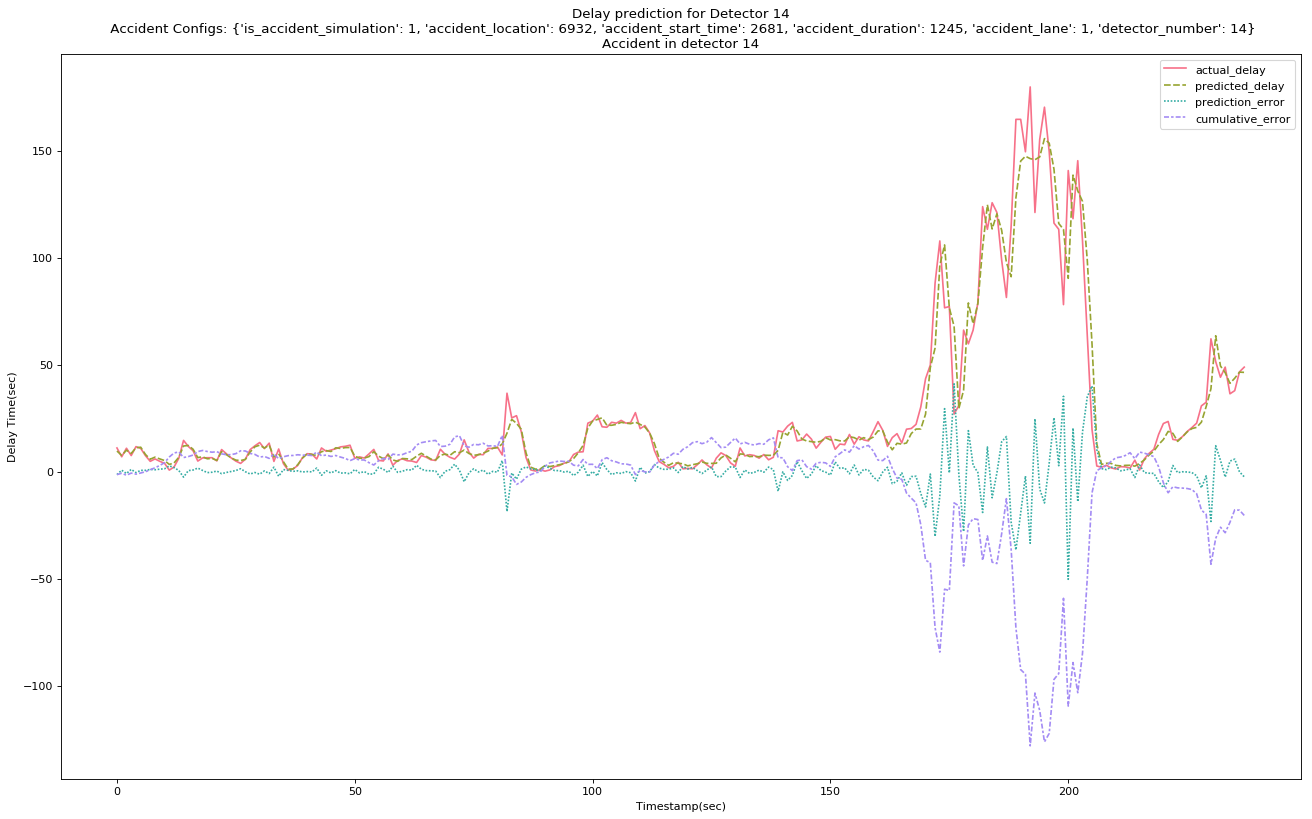

In [110]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
    "detector_number" : 14
}
plot_delay_predictions(df,simulation_configs)

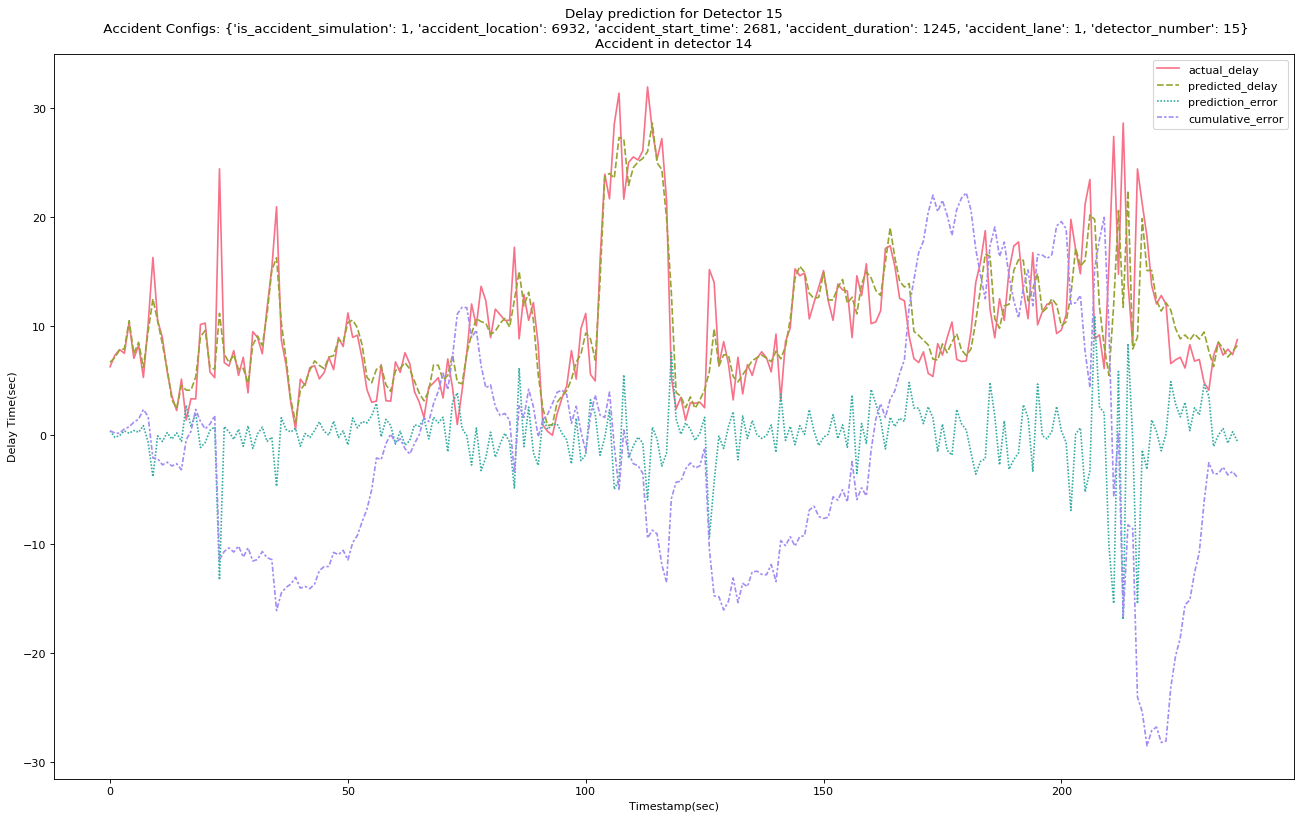

In [112]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
    "detector_number" : 15
}
plot_delay_predictions(df,simulation_configs)